In [6]:
# ============================================================================
# BASELINE MODELING - Decision Tree (No Feature Engineering)
# ============================================================================

# Purpose: Get a baseline performance metric before feature engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [7]:
# ============================================================================
# STEP 1: Load Preprocessed Data
# ============================================================================

# Load the model-ready dataset (77 features, 124,097 matches)
df = pd.read_csv('../data/processed/matches_final_without_player_context.csv')

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist()[:20], "...")  # Show first 20 columns
print(f"\nTarget variable distribution:")
print(df['player1_won'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")


✓ Data loaded successfully!
Shape: (124097, 77)

Columns (77):
['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A', 'player1_entry_3)'] ...

Target variable distribution:
player1_won
1    62253
0    61844
Name: count, dtype: int64

Missing values: 0


In [8]:
# ============================================================================
# STEP 2: Split Features and Target
# ============================================================================

# Separate features (X) and target (y)
X = df.drop('player1_won', axis=1)
y = df['player1_won']

print(f"✓ Features and target separated")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()[:10]}...")  # Show first 10

✓ Features and target separated
X shape: (124097, 76)
y shape: (124097,)

Feature columns: ['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'draw_size', 'tourney_date']...


In [9]:
# ============================================================================
# STEP 3: Train/Validation/Test Split by Date
# ============================================================================

# Split based on tourney_date column
# Train: 2014-2022 (dates < 20230000)
# Validation: 2023 (20230000 <= dates < 20240000)
# Test: 2024 (dates >= 20240000)

# Split the dataframe first
train_df = df[df['tourney_date'] < 20230000].copy()
val_df = df[(df['tourney_date'] >= 20230000) & (df['tourney_date'] < 20240000)].copy()
test_df = df[df['tourney_date'] >= 20240000].copy()

# Now separate X and y for each split, dropping tourney_date from features
X_train = train_df.drop(['player1_won', 'tourney_date'], axis=1)
y_train = train_df['player1_won']

X_val = val_df.drop(['player1_won', 'tourney_date'], axis=1)
y_val = val_df['player1_won']

X_test = test_df.drop(['player1_won', 'tourney_date'], axis=1)
y_test = test_df['player1_won']

print(f"✓ Data split by tournament date")
print(f"\nTrain set (2014-2022): {X_train.shape[0]:,} matches ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set (2023): {X_val.shape[0]:,} matches ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set (2024):       {X_test.shape[0]:,} matches ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nFeatures per set: {X_train.shape[1]} (tourney_date dropped)")
print(f"\nClass balance in train set:")
print(y_train.value_counts(normalize=True))


✓ Data split by tournament date

Train set (2014-2022): 96,328 matches (77.6%)
Validation set (2023): 13,584 matches (10.9%)
Test set (2024):       14,185 matches (11.4%)

Features per set: 75 (tourney_date dropped)

Class balance in train set:
player1_won
1    0.501433
0    0.498567
Name: proportion, dtype: float64


In [10]:
# ============================================================================
# STEP 4: Train Baseline Decision Tree
# ============================================================================

# Initialize Decision Tree with basic parameters
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model on TRAINING SET ONLY
print("Training Decision Tree...")
dt_model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Get predictions on all three sets
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)

print("\n" + "="*70)
print("BASELINE DECISION TREE PERFORMANCE")
print("="*70)


Training Decision Tree...
✓ Model trained successfully!

BASELINE DECISION TREE PERFORMANCE


In [11]:
# ============================================================================
# STEP 5: Evaluate Model Performance
# ============================================================================

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# Check for overfitting
print("\n" + "="*70)
print("OVERFITTING CHECK:")
print("="*70)
train_acc, val_acc, test_acc = train_metrics[0], val_metrics[0], test_metrics[0]
print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"\nTrain-Val Gap:  {(train_acc - val_acc)*100:.2f}%")
print(f"Train-Test Gap: {(train_acc - test_acc)*100:.2f}%")

if train_acc - val_acc > 0.05:
    print("\n⚠️  WARNING: Significant overfitting detected (>5% gap)")
else:
    print("\n✓ Model generalization looks reasonable")



Training Set Performance:
  Accuracy:  0.6596 (65.96%)
  Precision: 0.6674
  Recall:    0.6402
  F1-Score:  0.6536

Validation Set Performance:
  Accuracy:  0.6268 (62.68%)
  Precision: 0.6354
  Recall:    0.6082
  F1-Score:  0.6215

Test Set Performance:
  Accuracy:  0.6214 (62.14%)
  Precision: 0.6256
  Recall:    0.6091
  F1-Score:  0.6172

OVERFITTING CHECK:
Train Accuracy:      0.6596
Validation Accuracy: 0.6268
Test Accuracy:       0.6214

Train-Val Gap:  3.28%
Train-Test Gap: 3.82%

✓ Model generalization looks reasonable



CONFUSION MATRIX (Validation Set)

[[4354 2388]
 [2681 4161]]

True Negatives (TN):  4,354 (Player1 lost, predicted lost)
False Positives (FP): 2,388 (Player1 lost, predicted won)
False Negatives (FN): 2,681 (Player1 won, predicted lost)
True Positives (TP):  4,161 (Player1 won, predicted won)


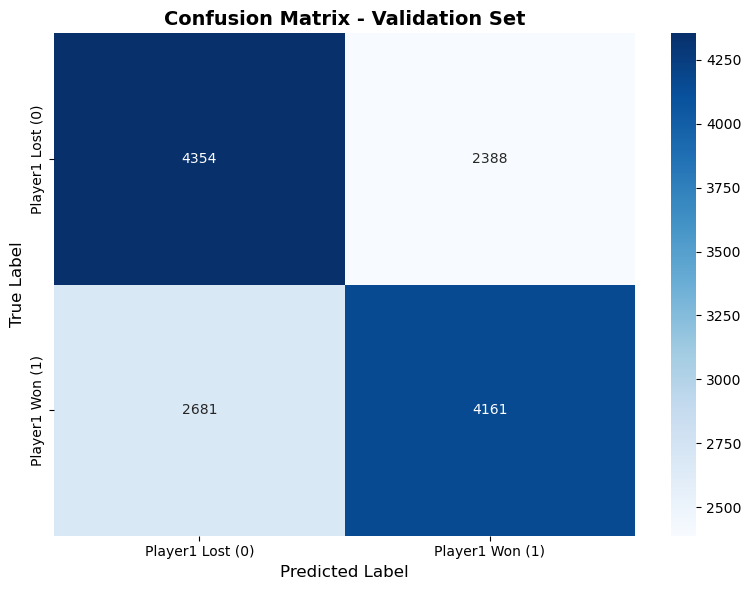


CLASSIFICATION REPORT (Validation Set)
              precision    recall  f1-score   support

Player1 Lost       0.62      0.65      0.63      6742
 Player1 Won       0.64      0.61      0.62      6842

    accuracy                           0.63     13584
   macro avg       0.63      0.63      0.63     13584
weighted avg       0.63      0.63      0.63     13584



In [12]:
# ============================================================================
# STEP 6: Confusion Matrix and Classification Report
# ============================================================================

# Validation set confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

print("\n" + "="*70)
print("CONFUSION MATRIX (Validation Set)")
print("="*70)
print(f"\n{cm_val}")
print(f"\nTrue Negatives (TN):  {cm_val[0,0]:,} (Player1 lost, predicted lost)")
print(f"False Positives (FP): {cm_val[0,1]:,} (Player1 lost, predicted won)")
print(f"False Negatives (FN): {cm_val[1,0]:,} (Player1 won, predicted lost)")
print(f"True Positives (TP):  {cm_val[1,1]:,} (Player1 won, predicted won)")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Player1 Lost (0)', 'Player1 Won (1)'],
            yticklabels=['Player1 Lost (0)', 'Player1 Won (1)'])
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT (Validation Set)")
print("="*70)
print(classification_report(y_val, y_val_pred, 
                          target_names=['Player1 Lost', 'Player1 Won']))



TOP 20 MOST IMPORTANT FEATURES
         feature  importance
    player1_rank    0.473997
    player2_rank    0.361163
     player2_age    0.041886
     player1_age    0.041696
      player1_ht    0.019698
      player2_ht    0.012638
 player2_entry_Q    0.004476
       draw_size    0.004074
player1_entry_PR    0.003497
 player1_entry_Q    0.003167
  player2_hand_U    0.002463
  player1_hand_U    0.002281
  player2_hand_L    0.002231
  player2_hand_R    0.001956
  player1_hand_R    0.001710
        round_QF    0.001536
       round_R64    0.001485
player2_entry_WC    0.001427
 tourney_level_C    0.001424
         best_of    0.001306


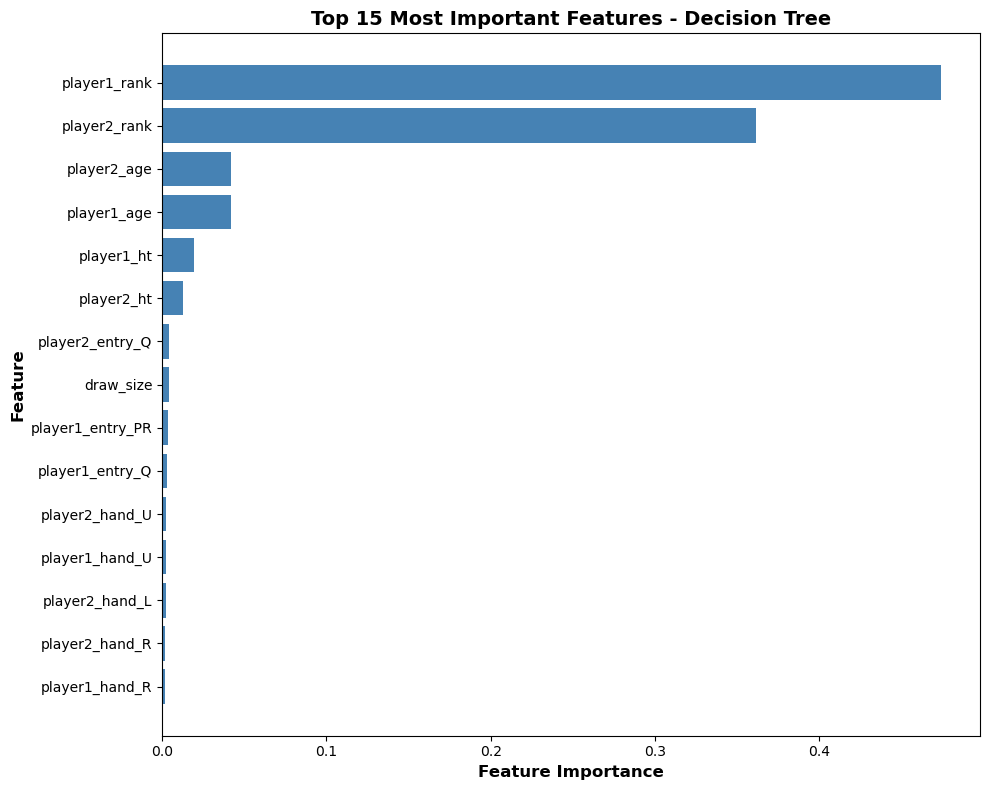


✓ Feature importance saved to '../results/baseline_dt_feature_importance.csv'


In [13]:
# ============================================================================
# STEP 7: Feature Importance Analysis
# ============================================================================

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance.to_csv('../results/baseline_dt_feature_importance.csv', index=False)
print("\n✓ Feature importance saved to '../results/baseline_dt_feature_importance.csv'")


In [14]:
# ============================================================================
# STEP 8: Summary and Next Steps
# ============================================================================

print("\n" + "="*70)
print("BASELINE MODEL SUMMARY")
print("="*70)

print(f"\n📊 MODEL: Decision Tree Classifier (No Feature Engineering)")
print(f"\n📁 DATASET:")
print(f"   - Total matches: {len(df):,}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Train: {len(X_train):,} matches (2014-2022)")
print(f"   - Validation: {len(X_val):,} matches (2023)")
print(f"   - Test: {len(X_test):,} matches (2024)")

print(f"\n🎯 PERFORMANCE:")
print(f"   - Train Accuracy:      {train_metrics[0]:.4f} ({train_metrics[0]*100:.2f}%)")
print(f"   - Validation Accuracy: {val_metrics[0]:.4f} ({val_metrics[0]*100:.2f}%)")
print(f"   - Test Accuracy:       {test_metrics[0]:.4f} ({test_metrics[0]*100:.2f}%)")
print(f"   - Validation F1-Score: {val_metrics[3]:.4f}")

print(f"\n🔑 KEY INSIGHTS:")
print(f"   - This is the BASELINE before feature engineering")
print(f"   - Top features are mostly rank-related (player1_rank, player2_rank)")
print(f"   - Overfitting gap: {(train_metrics[0] - val_metrics[0])*100:.2f}%")

print(f"\n📝 NEXT STEPS:")
print(f"   1. Feature Engineering (rank_diff, age_diff, surface win rates)")
print(f"   2. Try other models (Random Forest, XGBoost, Logistic Regression)")
print(f"   3. Hyperparameter tuning to reduce overfitting")
print(f"   4. Compare baseline vs engineered feature performance")

print("\n" + "="*70)



BASELINE MODEL SUMMARY

📊 MODEL: Decision Tree Classifier (No Feature Engineering)

📁 DATASET:
   - Total matches: 124,097
   - Features: 76
   - Train: 96,328 matches (2014-2022)
   - Validation: 13,584 matches (2023)
   - Test: 14,185 matches (2024)

🎯 PERFORMANCE:
   - Train Accuracy:      0.6596 (65.96%)
   - Validation Accuracy: 0.6268 (62.68%)
   - Test Accuracy:       0.6214 (62.14%)
   - Validation F1-Score: 0.6215

🔑 KEY INSIGHTS:
   - This is the BASELINE before feature engineering
   - Top features are mostly rank-related (player1_rank, player2_rank)
   - Overfitting gap: 3.28%

📝 NEXT STEPS:
   1. Feature Engineering (rank_diff, age_diff, surface win rates)
   2. Try other models (Random Forest, XGBoost, Logistic Regression)
   3. Hyperparameter tuning to reduce overfitting
   4. Compare baseline vs engineered feature performance

